In [89]:
%matplotlib inline
from IPython.html.widgets import FloatProgress
from IPython.display import display

In [90]:

import gensim
import pandas as pd
import numpy as np
from sklearn.metrics import recall_score, make_scorer, confusion_matrix, precision_score
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt

from create_dictionary import train_corpus, transform_doc2bow, tokenize
from sklearn.metrics.pairwise import cosine_similarity

from online_lsi_sim import sim_two_lsi, sim_all_lsi
from online_lda_sim import sim_two_lda, sim_all_lda
from word2vec_sim import sim_two_w2v, sim_all_w2v
from doc_sim import sim_two, sim_all

from create_model import *


In [91]:

dictionary = gensim.corpora.Dictionary.load("../data/SESE.gz")
fname = "../SESE/cleaned/sql-html-sample.csv"

so_dat = pd.read_csv(fname)
so_dat_main = so_dat[['id', 'title', 'bodyString', 'tagsString']]

label_dat = pd.read_csv("../SESE/labels/sql-html-js-2_labels.csv")


# build each feature, and model
corpus = train_corpus(so_dat_main['bodyString'].tolist(), dictionary)

# all these models have online learning support
print "training lda..."
lda_mod = gensim.models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=7, minimum_probability=0.0)
print "training lsi..."
lsi_mod = gensim.models.lsimodel.LsiModel(corpus, id2word=dictionary, num_topics=100)
print "training word2vec..."
w2v_mod = gensim.models.Word2Vec(min_count=5, sg=5)
sentences = [tokenize(x) for x in so_dat_main['bodyString'].tolist()]
w2v_mod.build_vocab(sentences )
w2v_mod.train(sentences)

training lda...
training lsi...
training word2vec...


227101

In [92]:

# do left join with labels.....
dat_combine = pd.merge(so_dat_main, label_dat)

# basically perform negative sampling to find weights to optimize these two cases....

# do stuff and output training dataset....(figure out how...)
# will be adhoc for future...

# train for recall..

# get the dups...
train = pd.read_csv("../SESE/cleaned/2016_link_dups_time_fix.csv")

In [93]:
def sim_query_all(single, docs, dictionary,
              lsi_mod, lda_mod, w2v_mod, prefix=""):
    """takes in two documents and computes similarity between
    both based on the models above, with all equal weights"""
    
    sim_vec = {'lsi': sim_all_lsi(single, docs, lsi_mod, dictionary).flatten().tolist(),
               'lda': sim_all_lda(single, docs, lda_mod, dictionary).flatten().tolist(), 
               'w2v': sim_all_w2v(single, docs, w2v_mod).flatten().tolist(), 
               'doc': sim_all(single, docs, dictionary).flatten().tolist()}
    df = pd.DataFrame(sim_vec)
    df.columns = [x+prefix for x in df.columns]
    return df

def sim_stackoverflow(single_dict, docs_df, columns, dictionary, 
                      lsi_mod, lda_mod, w2v_mod):
    """
    single_dict is a dictionary...
    
    docs_df is dataframe
    
    """
    
    #pd.concat([df1, df4], axis=1)
    if columns is None:
        columns = {'title': 'title', 
                   'body': 'bodyString', 
                   'tag': 'tagsString'}
    #print columns
    body_sim = sim_query_all(single_dict[columns['body']], docs_df[columns['body']].tolist(), 
                             dictionary, lsi_mod, lda_mod, w2v_mod, "_body")
    title_sim = sim_query_all(single_dict[columns['title']], docs_df[columns['title']].tolist(), 
                             dictionary, lsi_mod, lda_mod, w2v_mod, "_title")
    tag_sim = sim_query_all(single_dict[columns['tag']], docs_df[columns['tag']].tolist(), 
                             dictionary, lsi_mod, lda_mod, w2v_mod, "_tag")
    
    full_df = pd.concat([body_sim, title_sim, tag_sim], axis=1)
    return full_df

In [94]:
###

n_obs = 250
f = FloatProgress(min=0, max=n_obs-1)
display(f)

train_subset = train.iloc[:250]
train_labels = train_subset[['id', 'did']]
train_labels.loc[:, 'label'] = 1

m_ids = sorted(train_subset['id'].tolist(), key=lambda x: int(x))
d_ids = sorted(train_subset['did'].tolist(), key=lambda x: int(x))

ddict = {'title': 'dtitle', 
        'body': 'dbodyString', 
        'tag': 'dtagsString'}
    
train_feats = []

for idx, m_id in enumerate(m_ids):
    f.value = idx
    train_temp = train_subset[train_subset['id'].astype(int) <= int(m_id)]
    # restack dataframe...
    dtrain_temp = train_temp[['dbodyString', 'dtagsString', 'dtitle', 'did']]
    dtrain_temp.columns = [x[1:] for x in dtrain_temp.columns]
    train_temp = train_temp[['id', 'title', 'bodyString', 'tagsString']]
    train_temp = pd.concat([train_temp, dtrain_temp])
    train_temp = train_temp[train_temp['id'] != m_id]
    single_doc = train_subset[train_subset['id'] == m_ids[0]].to_dict(orient="records")[0]
    temp_feats = sim_stackoverflow(single_doc, train_temp, None, dictionary,
              lsi_mod, lda_mod, w2v_mod)
    # input column and dup col - to infer id. 
    temp_feats.loc[:, 'id'] = m_id
    temp_feats.loc[:, 'did'] = train_temp['id'].tolist() 
    train_feats.append(temp_feats)
    
feature_df = pd.merge(pd.concat(train_feats), train_labels, on=['id', 'did'], how='left').drop_duplicates()
feature_df['label'] = feature_df['label'].fillna(0)
feature_df.describe()



,doc_body,lda_body,lsi_body,w2v_body,doc_title,lda_title,lsi_title,w2v_title,doc_tag,lda_tag,lsi_tag,w2v_tag,label
count,62499.000000,62499.000000,62499.000000,62499.000000,62499.000000,62499.000000,62499.000000,62499.000000,62499.000000,62499.000000,62499.000000,62499.000000,62499.000000
mean,0.107023,0.324800,0.154382,0.893404,0.012779,0.180793,0.033475,0.742788,0.095002,0.314094,0.158746,0.842091,0.020320
std,0.108180,0.275779,0.133294,0.046012,0.081008,0.234265,0.121761,0.097612,0.183626,0.386350,0.283474,0.169038,0.141095
min,0.000000,0.003568,-0.055276,0.677800,0.000000,0.066703,-0.087266,0.000000,0.000000,0.035546,-0.119276,0.000000,0.000000
25%,0.029019,0.064078,0.057729,0.868148,0.000000,0.087272,-0.016586,0.705805,0.000000,0.057928,0.015844,0.840459,0.000000
50%,0.086103,0.229886,0.143478,0.891269,0.000000,0.100393,0.009193,0.741463,0.000000,0.070017,0.051864,0.876035,0.000000
75%,0.154369,0.508519,0.211684,0.928129,0.000000,0.125319,0.063044,0.803266,0.117851,0.555718,0.076179,0.914330,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [95]:
#feature_df.to_pickle("feature_df_lda3.pkl")

In [96]:
#feature_df = pd.read_pickle("feature.df.pkl") # where the hell did this one come from??

In [97]:
X = feature_df[[u'doc_body', u'lda_body', u'lsi_body', u'w2v_body', u'doc_title',
       u'lda_title', u'lsi_title', u'w2v_title', u'doc_tag', u'lda_tag',
       u'lsi_tag', u'w2v_tag']].as_matrix()
       
Y = feature_df[['label']].as_matrix().flatten()

In [98]:
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=2, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [99]:


rf.fit(X, Y)
#grid_search.predict(X)

print(confusion_matrix(Y, rf.predict(X)))
print(recall_score(Y, rf.predict(X)))


[[61228     1]
 [  412   858]]
0.675590551181


[[61229     0]
 [    1  1269]]
0.999212598425


C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:39: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


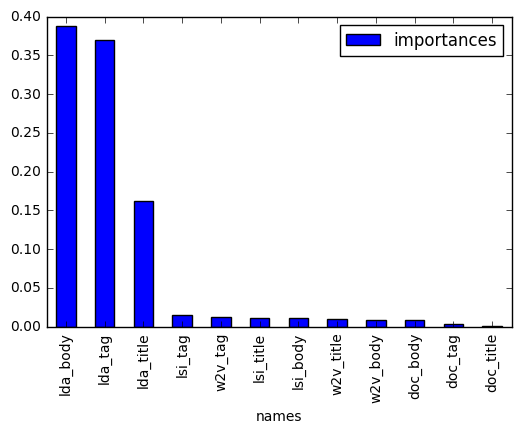

In [18]:
# randomforest classifier
clf = RandomForestClassifier(n_jobs=2)

recall_scorer = make_scorer(recall_score)
# use a full grid over all parameters

param_grid = {"n_estimators": [1000],
              "max_depth": [3, 6, None],
              "max_features": [1, 3, 10, 'sqrt', 'log2'],
              "bootstrap": [True],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(estimator=clf, 
                           param_grid=param_grid, 
                           scoring=recall_scorer)



grid_search.fit(X, Y)
#grid_search.predict(X)

print(confusion_matrix(Y, grid_search.predict(X)))
print(recall_score(Y, grid_search.predict(X)))





# build tree to see important feats?
feat_importance = grid_search.estimator.fit(X,Y).feature_importances_

feat_df = pd.DataFrame({
    'importances': feat_importance,
    'names': [u'doc_body', u'lda_body', u'lsi_body', u'w2v_body', u'doc_title',
       u'lda_title', u'lsi_title', u'w2v_title', u'doc_tag', u'lda_tag',
       u'lsi_tag', u'w2v_tag']
                        })
feat_df = feat_df.sort(['importances'], ascending=False)
feat_df.plot.bar(x="names", y="importances")

In [19]:
grid_search.estimator

"""
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=2, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
"""

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=2, oob_score=False, random_state=None,
            verbose=0, warm_start=False)